In [53]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:

class TrainModel:

    def __init__(self, epochs=2, execution_count=0, batch_size=32):
        self.execution_count = execution_count
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.train_data = None
        self.val_data = None
        self.train_labels = None
        self.val_labels = None
        cwd = os.getcwd()
        dir_path = os.path.join(cwd, f'experiments_{self.execution_count}')
        os.makedirs(dir_path, exist_ok=True)
        print(f"Directory created at: {dir_path}")
        self.train_path = os.path.join(dir_path, f'train.csv')
        self.test_path = os.path.join(dir_path, f'test.csv')
        self.graph_path = os.path.join(dir_path, f'graph.png')

    def build_model(self):
        """Build CNN model for MNIST classification"""
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(10, activation='softmax'))

        self.model.compile(
            optimizer=Adam(), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        print("Model built successfully!")
        # print(self.model.summary())

    def load_data(self):
        """Load and preprocess MNIST data"""
        print("Loading MNIST data...")
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        
        # CRITICAL FIX: Normalize pixel values to [0, 1] range
        self.x_train = self.x_train.astype('float32') / 255.0
        self.x_test = self.x_test.astype('float32') / 255.0
        
        # CRITICAL FIX: Reshape data to add channel dimension (28, 28, 1)
        self.x_train = self.x_train.reshape(-1, 28, 28, 1)
        self.x_test = self.x_test.reshape(-1, 28, 28, 1)
        
        # Shuffle training data
        RANDOM_SEED = 42
        np.random.seed(RANDOM_SEED)
        indices = np.arange(self.x_train.shape[0])
        np.random.shuffle(indices)
        
        self.x_train = self.x_train[indices]
        self.y_train = self.y_train[indices]
        
        # Split into train and validation
        self.train_data = self.x_train[:400]
        self.val_data = self.x_train[400:500]
        self.train_labels = self.y_train[:400]
        self.val_labels = self.y_train[400:500]
        
        print(f"Training data shape: {self.train_data.shape}")
        print(f"Validation data shape: {self.val_data.shape}")
        print(f"Test data shape: {self.x_test.shape}")

    def train_model(self, epochs=None, batch_size=None):
        """Train the model"""
        if epochs is None:
            epochs = self.epochs
        if batch_size is None:
            batch_size = self.batch_size
            
        print(f"Starting training for {epochs} epochs with batch size {batch_size}...")
        
        history = self.model.fit(
            self.train_data, 
            self.train_labels, 
            validation_data=(self.val_data, self.val_labels),
            epochs=epochs, 
            batch_size=batch_size,
            verbose=1
        )
        
        print("Training completed!")
        return history

    def evaluate_model(self):
        """Evaluate model on test data"""
        print("Evaluating model on test data...")
        test_loss, test_acc = self.model.evaluate(self.x_test, self.y_test, verbose=1)
        print(f'Test accuracy: {test_acc:.4f}')
        print(f'Test loss: {test_loss:.4f}')
        return test_loss, test_acc

    def show_history(self, history):
        """Plot training history"""
        print(history.history)
        plt.figure(figsize=(12, 4))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.savefig(self.graph_path)
        plt.show()
   
    def save_history(self, history, test_loss, test_acc):

        train = pd.DataFrame({
            'experiment_no': [self.execution_count]*len(history.history['loss']),
            'epoch': list(range(1, len(history.history['loss']) + 1)),
            'train_loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'train_accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy']
        })
        train.to_csv(self.train_path, index=False)
        print(f"Training history saved to {self.train_path}")
        test = pd.DataFrame({
            'experiment_no': [self.execution_count],
            'test_loss': [test_loss],
            'test_accuracy': [test_acc]
            })
        test.to_csv(self.test_path, index=False)
        print(f"Test results saved to {self.test_path}")

    def run_model(self):
        """Run complete training pipeline"""
        
        try:
            self.load_data()
            self.build_model()

            history = self.train_model(self.epochs, self.batch_size)
            test_loss, test_acc = self.evaluate_model()
            self.show_history(history)
            test_loss, test_acc = self.evaluate_model()
            self.save_history(history, test_loss, test_acc)
            return history, test_loss, test_acc
            
        except Exception as e:
            print(f"Error occurred during training: {str(e)}")
            print("Please check the error above and fix accordingly.")
            return None, None, None

    

Directory created at: /home/silicon/opencv_learn/quantum_computing/experiments_55
Loading MNIST data...
Training data shape: (400, 28, 28, 1)
Validation data shape: (100, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Model built successfully!
Starting training for 4 epochs with batch size 32...


/home/silicon/opencv_learn/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.2625 - loss: 2.2145 - val_accuracy: 0.4300 - val_loss: 1.7105
Epoch 2/4
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5487 - loss: 1.4499 - val_accuracy: 0.6700 - val_loss: 1.1402
Epoch 3/4
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7319 - loss: 0.9514 - val_accuracy: 0.6800 - val_loss: 0.9254
Epoch 4/4
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8426 - loss: 0.4574 - val_accuracy: 0.6800 - val_loss: 0.9210
Training completed!
Evaluating model on test data...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7597 - loss: 0.7776
Test accuracy: 0.7780
Test loss: 0.7003
{'accuracy': [0.3375000059604645, 0.5550000071525574, 0.7699999809265137, 0.8450000286102295], 'loss': [2.1063294410705566, 1.3740148544311523, 0.8158890008926392, 0.4487575888633728], 'val_accuracy': [0.4300000071525574, 0.6700000166893005, 0.6800000071525574, 0.6800000071525574], 'val_loss': [1.7104791402816772, 1.14021039

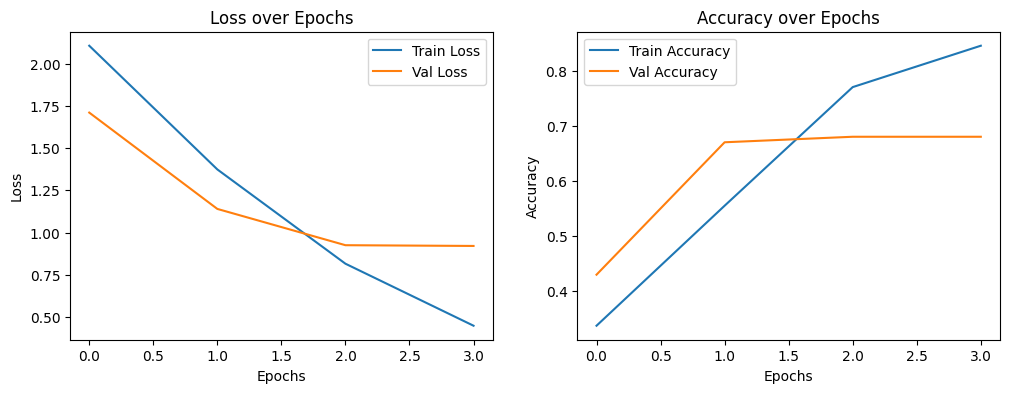

Evaluating model on test data...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7597 - loss: 0.7776
Test accuracy: 0.7780
Test loss: 0.7003
Training history saved to /home/silicon/opencv_learn/quantum_computing/experiments_55/train.csv
Test results saved to /home/silicon/opencv_learn/quantum_computing/experiments_55/test.csv


(<keras.src.callbacks.history.History at 0x7575308290a0>,
 0.7003393769264221,
 0.777999997138977)

In [55]:
x= TrainModel(epochs=4, execution_count=get_ipython().execution_count)
x.run_model()